In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

## Get started with quantum support vector regression (QSVR)

In this notebook, we show how to predict health insurance charges with quantum support vector regression (QSVR). To solve the health insurance regression problem, we enhance the classical support vector regression (SVR) with quantum kernel estimation (QKE).<sup>1</sup> Additionally, we apply a grid search to find the best set of parameters for our QKE.

#### Import packages

This tutorial assumes that all required packages have already been installed according to the installation instructions. 

In [30]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

from qiskit.circuit.library import PauliFeatureMap
from qiskit_aer.primitives import Sampler
from qiskit_machine_learning.kernels import FidelityStatevectorKernel

### Quantum kernel estimation

In general, kernels are used to give a measure of similarity between two vectors. 
A kernel in supervised and unsupervised machine learning is a function that computes the inner product between two vectors in a feature space. These vectors are derived from the original vectors in a Euclidean space by a mapping function that can be nonlinear. The feature space is usually a higher-dimensional space than the original data space.<sup>2</sup>

Kernel functions are used in model training and inference to substitute the explicit evaluation of the feature mapping functions (this is known as the kernel trick).
In quantum computing, we define the quantum kernel as the Hilbert-Schmidt inner product of two feature vectors $\rho (x)$, $\rho (y)$ as:

$$K(x,y) = tr[\rho (x) \rho (y)] = {\vert \langle \phi (y) \vert \phi (x) \rangle \vert}^{2},$$  
where the data is nonlinearly mapped to a quantum state $\phi : \vec{x} \in \Omega \rightarrow \vert\phi(x)\rangle\langle\phi(x)\vert$ with $\Omega \in \mathbb{R}^d$ is a subset of the entire data set that represents our test set.<sup>1</sup> We will rewrite this expression to show that we could use it as a similarity measure between our input $x$ and target $y$. Writing out the squared terms, we find the following:

$$ = \langle \phi (y) \vert \phi (x) \rangle^{\dagger} \langle \phi (y) \vert \phi (x) \rangle. $$
Next, we continue to rewrite this expression by using $\langle \phi (y) \vert \phi (x) \rangle^{\dagger} = \langle \phi (x) \vert \phi (y) \rangle$, which yields
$$ = \langle \phi (x) \vert \phi (y) \rangle \langle \phi (y) \vert \phi (x) \rangle, $$
Hence, $\rho(y) = \vert \phi(y) \rangle \langle \phi(y) \vert = U(y) \vert 0 \rangle \langle 0 \vert {U(y)}^{\dagger}$. Assuming pure states for simplicity,<sup>3</sup> we find 
$$ = \langle \phi (x) \vert \rho_y \vert \phi (x) \rangle. $$

This final identity is a measurement $\langle \phi (x) \vert \rho_y \vert \phi (x) \rangle$, which provides us with information on a given input $x$ in feature space $\phi(x)$ regarding the probability of measuring our target $\rho_y$. To obtain an estimate of this probability, we need to repeat this measurement a number of times. As such, we estimate our quantum kernel.<sup>1</sup>


### Data preparation

#### Import the data

We use the Kaggle Insurance Premium Prediction data set<sup>4</sup> to demonstrate the potential effectiveness of the quantum algorithm. This data set has six independent features and one dependent feature. The six independent features are age, sex, BMI (body mass index), children, smoker, and region. The dependent feature is charge. In total, this data set contains 1,338 observations. 

In [16]:
# You can find the data set and details on Kaggle in the link above
df1 = pd.read_csv('insurance.csv')

In [17]:
df1.shape

(1338, 7)

In [18]:
df1.head(5)

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

The data set contains four numerical features and three categorical features. Next, we convert the categorical features into factors with numerical values, where `1` means “true” and `0` means “false.” 

In [19]:
# Convert categorical data to 0 or 1
df = pd.get_dummies(df1, drop_first=True)
df

age     bmi  children      charges  sex_male  smoker_yes  \
0      19  27.900         0  16884.92400     False        True   
1      18  33.770         1   1725.55230      True       False   
2      28  33.000         3   4449.46200      True       False   
3      33  22.705         0  21984.47061      True       False   
4      32  28.880         0   3866.85520      True       False   
...   ...     ...       ...          ...       ...         ...   
1333   50  30.970         3  10600.54830      True       False   
1334   18  31.920         0   2205.98080     False       False   
1335   18  36.850         0   1629.83350     False       False   
1336   21  25.800         0   2007.94500     False       False   
1337   61  29.070         0  29141.36030     False        True   

      region_northwest  region_southeast  region_southwest  
0                False             False              True  
1                False              True             False  
2                False              True             False  
3                 True             False             False  
4                 True             False             False  
...                ...               ...               ...  
1333              True             False             False  
1334             False             False             False  
1335             False              True             False  
1336             False             False              True  
1337              True             False             False  

[1338 rows x 9 columns]

#### Split the data into train, test, and validation sets
Below we create our train, test, and validation sets. After splitting it, the data is scaled with `MinMaxScaler()`. Finally, we use a predefined scheme for the train and validation sets. 

In [20]:
# Create input feature matrix X and target vector y
X = df.drop('charges', axis=1)
y = df.charges

In [21]:
# Split data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

#### Scale the data

In [22]:
mms = MinMaxScaler(feature_range=(0, np.pi))
X_train = mms.fit_transform(X_train)
X_val = mms.transform(X_val)
X_test = mms.transform(X_test)

mms_y = MinMaxScaler(feature_range=(0, np.pi))
y_train = mms.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_val = mms.transform(y_val.values.reshape(-1, 1)).ravel()
y_test = mms.transform(y_test.values.reshape(-1, 1)).ravel()

#### Predefine the splits

In [23]:
X_train_val = np.concatenate((X_train, X_val),axis=0)
y_train_val = np.concatenate((y_train, y_val),axis=0)

predefined_split = np.concatenate(([-1]*y_train.shape[0], \
                                   [0]*y_val.shape[0]))
ps = PredefinedSplit(predefined_split)


In [24]:
predefined_split.shape

(1070,)

### Implementation

#### Quantum support vector regression

To predict the health insurance charges, we quantum-enhance the support vector regressor (QSVR)<sup>5</sup> with quantum kernel estimation (QKE). In general, the SVR aims to find a function $f(x)$ which predicts values no greater than $\epsilon$ apart from the target $y_n$ for each input $x$.<sup>6</sup> The linear regression model is given by

   $$f(x)=\omega^tx +\beta,$$

where $x$ is the input, $\omega$ the weight, and $\beta$ the bias. Hence, the SVR takes a similar form as the support vector classifier (SVC) but with important differences. The difference between the SVR and SVC algorithms is the regression loss function and constraints. The loss function is given by 

   $$V(y_i-f(x_i)) =  \begin{cases} 
         0, \text{if} \space |y_i-f(x_i)|\leq \epsilon  \\
         |y_i-f(x_i)|-\epsilon, \text{otherwise}. \\
      \end{cases}
   $$

Note: Only a small subset of the predictions a distant $\epsilon$ apart from the true value $y_i$ contribute to the loss.<sup>6</sup> To obtain the best estimate $\hat{f}(x)$, we need to find the best $\hat{w}$ that minimizes $V(y_i-f(x_i))$ and the margin $||\omega||^2$. This is done through the following function:

$$\min_{\omega}\sum^N_{i=0} V(y_i-f(x_i))+\frac{\lambda}{2}||\omega||^2,$$

which is the primal formulation of the Lagrangian. What’s more, there exists the dual formulation of the Lagrangian. The dual formulation is used in practice by SVR as it has some computational benefits over the primal formulation.<sup>6</sup> It is also the dual formulation in combination with the kernel trick that allows us to apply QKE. The dual formulation of the SVR optimization problem is given by

$$\max_{\alpha,\alpha^*} \epsilon \sum^N_{i=1}(\alpha_i+\alpha_i^*)-\sum^N_{i=1}y_i(\alpha_i^*-\alpha_i) +\frac{1}{2}\sum^N_{i=1}\sum^N_{j=1}(\alpha_i^*-\alpha_i)(\alpha_j^*-\alpha_j)K(x_i,x_j).$$

With subject constraints:<br>
- $\sum^N_{n=1}(\alpha_i-\alpha_i^*)=0$<br>
- $\forall n : 0\le \alpha_i \le \frac{1}{\lambda} $<br>
- $\forall n : 0\le \alpha_i^* \le \frac{1}{\lambda}$
- $\alpha_i \alpha_i^*=0$

Here $\lambda$ is a regularization parameter, and $\alpha_n$ and $\alpha_n^*$ are non-negative Lagrangian multipliers of the dual formulation.<sup>5</sup> Solving the dual formulation and mapping the input to a higher-dimensional space through a feature map $\phi:x \mapsto \phi(x)$ results in $\omega= \sum_{i=1}^N(\alpha_i^*-\alpha_i)\phi(x_i)$. Substituting this into our solution equation results in

$$\hat{f}(x) = \sum^N_{j=1} (\alpha_j^*-\alpha_j)K(x,v_j)+\beta_0,$$

where $\alpha_n$ and $\alpha_n^*$ are nonnegative Lagrangian multipliers for each observation $v_j$, $K(x,v_j)$ the kernel, and the bias $\beta_0$. In QSVR, the SVR algorithm aims to fit a regression hyperplane to quantum feature vectors in a nonlinear, higher-dimensional feature space, which in QSVR is an exponentially larger quantum Hilbert space of size $2^n$. This results in the following kernel: $K(x,x_i)=\vert \langle \phi (x) \vert \phi (x_i) \rangle \vert^{2}.$


What’s more, we perform a hyperparameter search to find the best set of hyperparameters for our QSVR. Unlike classical models, a change of hyperparameters in quantum leads to different models with new decision boundaries. The best set of hyperparameters will result in the highest $r^2$ score of the QSVR. In this notebook, we choose the `PauliFeatureMap`.<sup>7</sup> This feature map applies the following transformation to the input data $\vec{x}\in R^n$:  

$$U_{\Phi(\vec{x})}=\exp\left(i\sum_{S\subseteq [n]}\phi_S(\vec{x})\prod_{i\in S} P_i\right),$$

where $P_i \in\{I,X,Y,Z\}$ are the Pauli matrices. The index $S$ describes the connectivity between different qubit data points:
$S\in\{\binom{n}{k} \space combinations \space k=1,2,..,n\}$, which results in 

$$\phi_S(\vec{x}) = \begin{cases}
            x_0, \text{ if } k = 1 \\
            \prod_{j \in S} (\pi - x_j), \text{ otherwise,}
            \end{cases}$$

where the hyperparameter $\alpha$ is the Pauli rotation factor. This circuit could contain repetitions ($reps$) of this transformation. We choose to optimize only our QKE for the parameters $\alpha$ and Pauli matrices as our aim is to demonstrate the algorithm. Notice that the kernel dictionary (`kernel_dic`) is made in such a way that you can easily extend the grid search over other hyperparameters. 


In [26]:
# Define the Sampler
options =  {"shots":10000, 
            "seed":314}
sampler = Sampler(run_options=options)

Next, we define our hyperparameter grid, over which we search, along with the feature map. 

In [33]:
kernels = [] # list for kernel callables
kernels_dict = dict() # dictionary for lookup of kernel parameters

# Kernels grid
grid_params_kernel = dict()
grid_params_kernel["alpha"] = [0.5,1,2]
grid_params_kernel["paulis"] = [['Z', 'YY'], ["ZZ"],["YZ"]]
grid_params_kernel["reps"] = [1]
grid_params_kernel["entanglement"] = ["linear"]

feature_dim = X_train.shape[1]

# Extracting all combinations of kernel parameters
grid_params_kernel_values = \
    list(itertools.product(*grid_params_kernel.values()))

# Converting parameters grid into list of kernel callables
for alpha,pauli,reps,entanglement in grid_params_kernel_values:

    feature_map = PauliFeatureMap(feature_dimension=feature_dim, \
                                  alpha=alpha, \
                                  reps=reps, \
                                  paulis=pauli, \
                                  entanglement=entanglement \
                                 )


    #fidelity = ComputeUncompute(sampler=sampler)
    kernel = FidelityStatevectorKernel(feature_map=feature_map)
    obj_str = str(kernel)
    obj_str = obj_str[obj_str.find("0x"):-1]

    kernels_dict[obj_str] = {"alpha":alpha, \
                             "paulis":pauli, \
                             "reps":reps, \
                             "entanglement":entanglement
                            }

    kernels.append(kernel.evaluate)

In [34]:
# Define classical parameter grid for SVM with quantum kernel
params_qsvr = {'C':[1]}

# We use kernel objects themselves as parameters. 
# After the training we would need to map the selected kernel 
# back to kernel parameters.
params_qsvr['kernel'] = kernels
multimetric_scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

# Estimator to be used in GridSearchCV
svr = SVR() 


# Define grid search estimator with parameters grid, 
# predefined split and parallel processing
estimator_q = GridSearchCV(svr, params_qsvr, n_jobs=None, verbose=1, cv=ps, scoring=multimetric_scoring,  refit='r2')
estimator_q.fit(X = X_train_val,y = y_train_val)

# The next line is very verbose. Please, uncomment to see 
# detailed results.
# print(All results -----------, estimator.cv_results_)
print("Best ------------------\n", estimator_q.best_params_)
q_kernel_obj_str = str(estimator_q.best_params_.get('kernel'))
# Retrieving kernel parameters for the best kernel
q_kernel_obj_str = q_kernel_obj_str[q_kernel_obj_str.find("0x"):-2]
print("Best kernel -----------\n",kernels_dict[q_kernel_obj_str])

Fitting 1 folds for each of 9 candidates, totalling 9 fits
Best ------------------
 {'C': 1, 'kernel': <bound method FidelityStatevectorKernel.evaluate of <qiskit_machine_learning.kernels.fidelity_statevector_kernel.FidelityStatevectorKernel object at 0x7f7cfd56b5b0>>}
Best kernel -----------
 {'alpha': 0.5, 'paulis': ['Z', 'YY'], 'reps': 1, 'entanglement': 'linear'}


In [35]:
# Retrieve kernel parameters for grid search iterations
test_scores = estimator_q.cv_results_['mean_test_r2']
params = estimator_q.cv_results_['params']

for i_param in params:
    q_kernel_obj_str = str(i_param['kernel'])
    q_kernel_obj_str = q_kernel_obj_str[q_kernel_obj_str.find("0x"):-2]
    i_param["kernel"] = kernels_dict[q_kernel_obj_str]

for i,i_param in enumerate(params):
    i_param['test_score'] = test_scores[i]

In [36]:
with pd.option_context('display.max_rows', None, \
                       'display.max_columns', None, \
                       'max_colwidth', None, \
                       'display.width', 1000 \
                      ):
    print(pd.DataFrame(params))

   C                                                                      kernel  test_score
0  1  {'alpha': 0.5, 'paulis': ['Z', 'YY'], 'reps': 1, 'entanglement': 'linear'}    0.783996
1  1       {'alpha': 0.5, 'paulis': ['ZZ'], 'reps': 1, 'entanglement': 'linear'}    0.717047
2  1       {'alpha': 0.5, 'paulis': ['YZ'], 'reps': 1, 'entanglement': 'linear'}    0.717047
3  1    {'alpha': 1, 'paulis': ['Z', 'YY'], 'reps': 1, 'entanglement': 'linear'}    0.649680
4  1         {'alpha': 1, 'paulis': ['ZZ'], 'reps': 1, 'entanglement': 'linear'}    0.554690
5  1         {'alpha': 1, 'paulis': ['YZ'], 'reps': 1, 'entanglement': 'linear'}    0.554664
6  1    {'alpha': 2, 'paulis': ['Z', 'YY'], 'reps': 1, 'entanglement': 'linear'}    0.528630
7  1         {'alpha': 2, 'paulis': ['ZZ'], 'reps': 1, 'entanglement': 'linear'}    0.430738
8  1         {'alpha': 2, 'paulis': ['YZ'], 'reps': 1, 'entanglement': 'linear'}    0.430738


### Result

Next, we use the best quantum kernel for the QSVR given by the grid search to predict the health insurance charges. 

In [37]:
y_train_pred_q = estimator_q.best_estimator_.predict(X_train)
y_train_pred_scores_q = estimator_q.best_estimator_.score(X_train,y_train)

y_test_pred_q = estimator_q.best_estimator_.predict(X_test)
y_test_pred_scores_q = estimator_q.best_estimator_.score(X_test,y_test)

y_val_pred_q = estimator_q.best_estimator_.predict(X_val)
y_val_pred_scores_q = estimator_q.best_estimator_.score(X_val,y_val)


In [38]:
print("--- Results r2 score---")
print("Train: ", y_train_pred_scores_q.round(2))
print("Test: ", y_test_pred_scores_q.round(2))
print("Validation: ",y_val_pred_scores_q.round(2))

--- Results r2 score---
Train:  0.87
Test:  0.85
Validation:  0.83


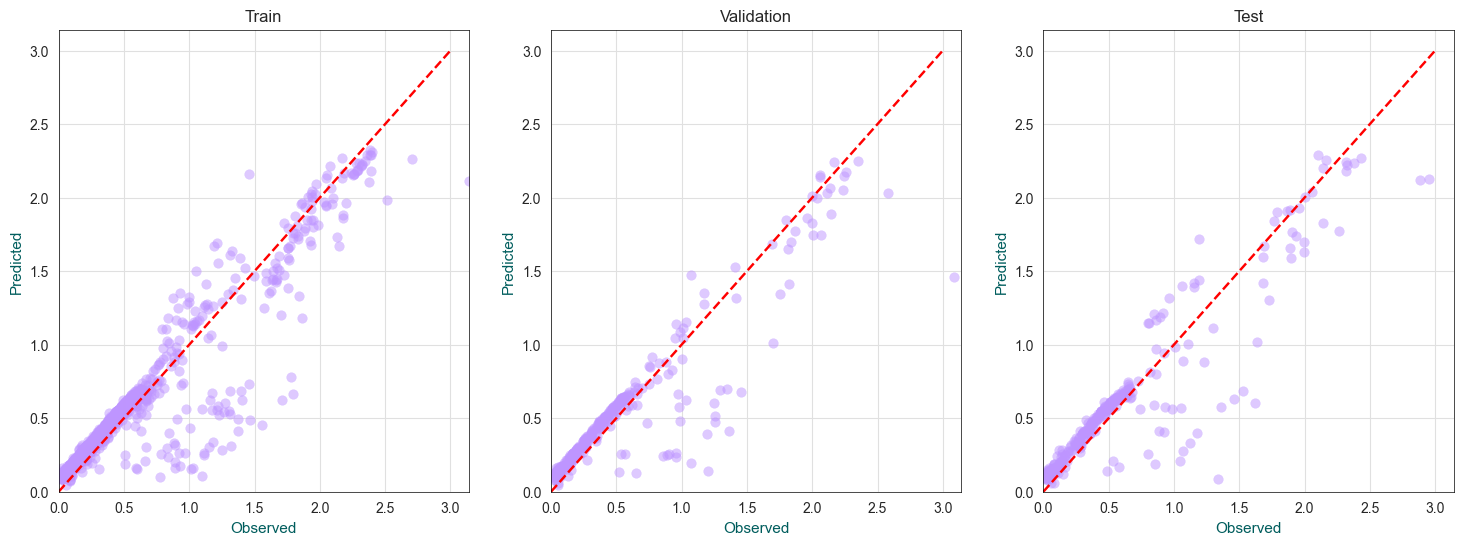

In [39]:
# Visualizing predicted–observed across train, validation and test subsets.

max_lim = max([y_train.max(),y_val.max(),y_test.max()])

fig, axs = plt.subplots(1, 3, figsize=(18,6))
axs[0].scatter(y_train, y_train_pred_q, alpha=0.5,c="#be95ff")
axs[0].set_title("Train")
axs[0].set_ylabel('Predicted')
axs[0].set_xlabel('Observed')
axs[0].plot(np.linspace(0, int(y_train.max().round()), 10),
         np.linspace(0, int(y_train.max().round()), 10), 'r--')
axs[0].grid()
axs[0].set_xlim(0, max_lim)
axs[0].set_ylim(0, max_lim)

axs[1].scatter(y_val, y_val_pred_q, alpha=0.5, c= "#be95ff")
axs[1].set_title("Validation")
axs[1].set_ylabel('Predicted')
axs[1].set_xlabel('Observed')
axs[1].plot(np.linspace(0, int(y_val.max().round()), 10),
         np.linspace(0, int(y_val.max().round()), 10), 'r--')
axs[1].grid()
axs[1].set_xlim(0, max_lim)
axs[1].set_ylim(0, max_lim)

axs[2].scatter(y_test, y_test_pred_q, alpha=0.5, c= "#be95ff")
axs[2].set_title("Test")
axs[2].set_ylabel('Predicted')
axs[2].set_xlabel('Observed')
axs[2].plot(np.linspace(0, int(y_test.max().round()), 10),
         np.linspace(0, int(y_test.max().round()), 10), 'r--')
axs[2].grid()
axs[2].set_xlim(0, max_lim)
axs[2].set_ylim(0, max_lim)

plt.show()

### Classical SVR

In [40]:

# Specify grid for SVM
parameters_svm = {'kernel':('linear', 'rbf'), \
              'C':[0.1, 1, 10, 100], \
              'gamma':['scale', 'auto',0.0001,0.001,0.01,0.1,1,10]
             } #, 'sigmoid'
# Initialize classifier and fit
svc = SVR()
estimator_r = GridSearchCV(svc, parameters_svm, n_jobs=-1, \
                           verbose=1, cv=5, scoring=multimetric_scoring,  refit='r2')
estimator_r.fit(X = X_train_val,y = y_train_val)

selected_params = estimator_r.best_estimator_.get_params()
selected_params = {k: selected_params[k] for k in \
                   parameters_svm.keys()}

print("Selected parameters:/n",selected_params)

y_train_pred_r = estimator_r.best_estimator_.predict(X_train)
y_train_pred_scores_r = estimator_r.best_estimator_.score(X_train,y_train)

y_test_pred_r = estimator_r.best_estimator_.predict(X_test)
y_test_pred_scores_r = estimator_r.best_estimator_.score(X_test,y_test)

y_val_pred_r = estimator_r.best_estimator_.predict(X_val)
y_val_pred_scores_r = estimator_r.best_estimator_.score(X_val,y_val)

print("--- Results r2 score---")
print("Train: ", y_train_pred_scores_r.round(4))
print("Test: ", y_test_pred_scores_r.round(4))
print("Validation: ",y_val_pred_scores_r.round(4))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Selected parameters:/n {'kernel': 'rbf', 'C': 100, 'gamma': 0.01}
--- Results r2 score---
Train:  0.8538
Test:  0.8573
Validation:  0.8169


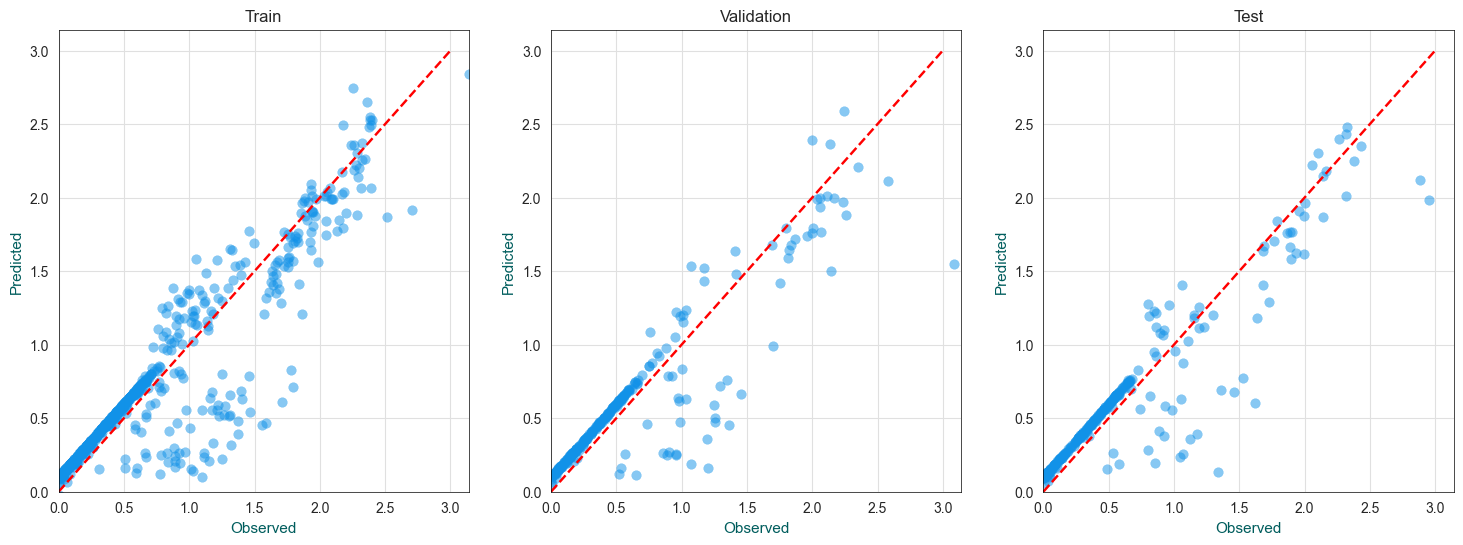

In [41]:
# Visualizing predicted-observed across train, validation and test subsets.

max_lim = max([y_train.max(),y_val.max(),y_test.max()])

fig, axs = plt.subplots(1, 3, figsize=(18,6))
axs[0].scatter(y_train, y_train_pred_r, alpha=0.5)
axs[0].set_title("Train")
axs[0].set_ylabel('Predicted')
axs[0].set_xlabel('Observed')
axs[0].plot(np.linspace(0, int(y_train.max().round()), 10),
         np.linspace(0, int(y_train.max().round()), 10), 'r--')
axs[0].grid()
axs[0].set_xlim(0, max_lim)
axs[0].set_ylim(0, max_lim)

axs[1].scatter(y_val, y_val_pred_r, alpha=0.5)
axs[1].set_title("Validation")
axs[1].set_ylabel('Predicted')
axs[1].set_xlabel('Observed')
axs[1].plot(np.linspace(0, int(y_val.max().round()), 10),
         np.linspace(0, int(y_val.max().round()), 10), 'r--')
axs[1].grid()
axs[1].set_xlim(0, max_lim)
axs[1].set_ylim(0, max_lim)

axs[2].scatter(y_test, y_test_pred_r, alpha=0.5)
axs[2].set_title("Test")
axs[2].set_ylabel('Predicted')
axs[2].set_xlabel('Observed')
axs[2].plot(np.linspace(0, int(y_test.max().round()), 10),
         np.linspace(0, int(y_test.max().round()), 10), 'r--')
axs[2].grid()
axs[2].set_xlim(0, max_lim)
axs[2].set_ylim(0, max_lim)

plt.show()

### Comparison

In [42]:
print("\t--- Results summary r2 score ---")
print("--- Classical --- \t \t --- Quantum ---")
print("Train: ", y_train_pred_scores_r.round(2)," \t\t\t Train: ", y_train_pred_scores_q.round(2))
print("Test: ", y_test_pred_scores_r.round(2), "\t\t\t Test: ", y_test_pred_scores_q.round(2))
print("Validation: ",y_val_pred_scores_r.round(2),"\t\t Validation: ",y_val_pred_scores_q.round(2))

	--- Results summary r2 score ---
--- Classical --- 	 	 --- Quantum ---
Train:  0.85  			 Train:  0.87
Test:  0.86 			 Test:  0.85
Validation:  0.82 		 Validation:  0.83


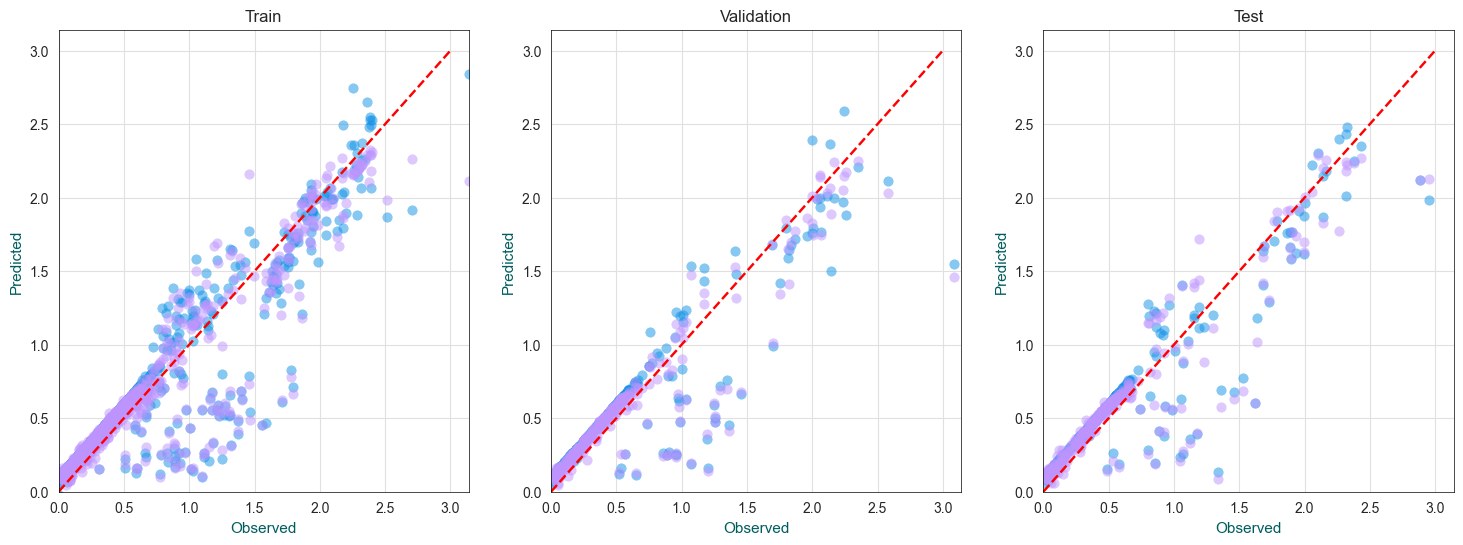

In [43]:
# Visualizing predicted-observed across train, validation and test subsets.

max_lim = max([y_train.max(),y_val.max(),y_test.max()])

fig, axs = plt.subplots(1, 3, figsize=(18,6))
axs[0].scatter(y_train, y_train_pred_r, alpha=0.5)
axs[0].scatter(y_train, y_train_pred_q, alpha=0.5,c="#be95ff")
axs[0].set_title("Train")
axs[0].set_ylabel('Predicted')
axs[0].set_xlabel('Observed')
axs[0].plot(np.linspace(0, int(y_train.max().round()), 10),
         np.linspace(0, int(y_train.max().round()), 10), 'r--')
axs[0].grid()
axs[0].set_xlim(0, max_lim)
axs[0].set_ylim(0, max_lim)

axs[1].scatter(y_val, y_val_pred_r, alpha=0.5)
axs[1].scatter(y_val, y_val_pred_q, alpha=0.5,c="#be95ff")
axs[1].set_title("Validation")
axs[1].set_ylabel('Predicted')
axs[1].set_xlabel('Observed')
axs[1].plot(np.linspace(0, int(y_val.max().round()), 10),
         np.linspace(0, int(y_val.max().round()), 10), 'r--')
axs[1].grid()
axs[1].set_xlim(0, max_lim)
axs[1].set_ylim(0, max_lim)

axs[2].scatter(y_test, y_test_pred_r, alpha=0.5)
axs[2].scatter(y_test, y_test_pred_q, alpha=0.5,c="#be95ff")
axs[2].set_title("Test")
axs[2].set_ylabel('Predicted')
axs[2].set_xlabel('Observed')
axs[2].plot(np.linspace(0, int(y_test.max().round()), 10),
         np.linspace(0, int(y_test.max().round()), 10), 'r--')
axs[2].grid()
axs[2].set_xlim(0, max_lim)
axs[2].set_ylim(0, max_lim)

plt.show()

The above graph shows the results of the classical models (blue) and the QSVR (purple) with a `PauliFeatureMap` with Z and YY rotation. 

### References

1. <a id='Havlicek2019'></a>Vojtech Havlicek et al. “Supervised Learning with Quantum Enhanced Feature Spaces.” arXiv:1804.11326, 2018. https://arxiv.org/abs/1804.11326.

2. <a id='Hofmann2008'></a>Thomas Hofmann, Bernhard Schölkopf, and Alexander J. Smola, “Kernel Methods in Machine Learning.” arXiv:math/0701907, 2008. https://arxiv.org/abs/math/0701907.

3. <a id='Schuld2021'></a>Maria Schuld, “Supervised Quantum Machine Learning Models Are Kernel Methods.” arXiv:2101.11020, 2021. https://arxiv.org/abs/2101.11020.

4. <a id='KaggleData2020'></a>“Insurance Premium Data.” *Kaggle*, 2020. https://www.kaggle.com/datasets/simranjain17/insurance.

5. <a id='Drucker1996'></a>Harris Drucker et al. “Support Vector Regression Machines.” *NeurIPS Proceedings*, 1996. https://proceedings.neurips.cc/paper/1996/file/d38901788c533e8286cb6400b40b386d-Paper.pdf.

6. <a id='Hastie2009'></a>Trevor Hastie, Jerome Friedman, and Robert Tibshirani. *The Elements of Statistical Learning: Data Mining, Inference, and Prediction*. Springer Series in Statistics. New York: Springer, 2009. https://link.springer.com/book/10.1007/978-0-387-21606-5.

7. <a id='QiskitPauli'></a>“PauliFeatureMap.” *Qiskit*. https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliFeatureMap.html.

<span style="font-size:10pt; font-weight:bold;" class = "copyright-content"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>